Data preprocessing

Add locations, time, day to each fetched file

In [302]:

import pandas as pd

# Read different CSV files collected at different times and locations
file_path = '/Users/macbook/Desktop/9336/dataset/FRI09cse.csv'  
df = pd.read_csv(file_path, low_memory=False, encoding='ISO-8859-1')

# Add three columns of location,time and day
df['Loation'] = 'CSE_Building'
df['Time_of_day'] = '09'
df['Day'] = 'Friday'


df.to_csv('/Users/macbook/Desktop/9336/dataset/FRI09cse.csv', index=False)


Get Sequence Number, Calculate retransmission count

In [303]:
import pandas as pd

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/FRI09cse.csv', encoding='utf_8')

# Extract SN and convert to a floating point number
data['Sequence Number'] = data['Info'].str.extract(r'[sS][nN]\s*=\s*(\d+)').astype(float)

# Remove rows where 'Sequence Number' cannot be extracted
data.dropna(subset=['Sequence Number'], inplace=True)

# Determine the packet is retransmitted
data['Retransmission Flag'] = data.duplicated(
    subset=['Source', 'Destination', 'Length', 'Protocol', 'Sequence Number'],
    keep=False
).astype(int)

# Set the number of retransmissions 
data['Retransmission Count'] = data.groupby(
    ['Source', 'Destination', 'Length', 'Protocol', 'Sequence Number']
).cumcount()

data.to_csv('/Users/macbook/Desktop/9336/dataset/FRI09cse.csv', index=False)



The transmission time interval of consecutive packets reflects the variation of network load and transmission delay. Under some network conditions, the time interval between two packet transmissions and the actual transmission delay of a single packet are relatively close. An approximate delay value can be obtained by calculating the sending time difference of two consecutive packets.

In [72]:
import pandas as pd

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/FRI09cse.csv', encoding='utf_8')

data['absolute time'] = pd.to_datetime(data['Time'], errors='coerce')

# Sort by absolute time
data = data.sort_values(by='absolute time').reset_index(drop=True)

# Computation latency
data['Latency'] = data['absolute time'].diff().dt.total_seconds()

# The latency of the first packet is set to NaN
data['Latency'].iloc[0] = None

data.to_csv('/Users/macbook/Desktop/9336/dataset/FRI09cse.csv', index=False)

/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/2267929817.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Latency'].iloc[0] = None
/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/2267929817.py:15

Merge all files into a single file

In [305]:
import pandas as pd
import glob

file_paths = glob.glob('/Users/macbook/Desktop/9336/dataset/*.csv')  

data_frames = [pd.read_csv(file) for file in file_paths]  
merged_data = pd.concat(data_frames, ignore_index=True)   

# Save the merged data to a new CSV file
merged_data.to_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', index=False)  


Process Frame Type,Signal strength,Noise level,Signal/noise ratio and Packet size, calculate throughput and channel utilization

In [74]:
import pandas as pd

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', encoding='utf_8')

data['Signal Strength'] = data['Signal strength (dBm)'].str.replace(' dBm', '').astype(float)
data['Noise level'] = data['Noise level (dBm)'].str.replace(' dBm', '').astype(float)
data['Signal/noise ratio'] = data['Signal/noise ratio (dB)'].str.replace(' dB', '').astype(float)
data['Packet Size'] = data['Length']
data['Channel Utilization'] = data['Length'] / data['Length'].sum() * 100

data['Frame Type'] = data['Protocol'].apply(lambda x: 'Management' if 'management' in str(x).lower()
                                            else 'Control' if 'control' in str(x).lower()
                                            else 'Data')

data['absolute time'] = pd.to_datetime(data['absolute time'], errors='coerce')

if data['absolute time'].notna().all():
    total_duration = (data['absolute time'].max() - data['absolute time'].min()).total_seconds()
    throughput_per_device = data.groupby('Source')['Packet Size'].sum() / total_duration
    data['Throughput'] = data['Source'].map(throughput_per_device)
else:
    print("Warning: 'absolute time' contains NaT values, which may affect calculations.")

data.to_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', index=False)

/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/793660908.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['absolute time'] = pd.to_datetime(data['absolute time'], errors='coerce')


Plot the retransmission histogram

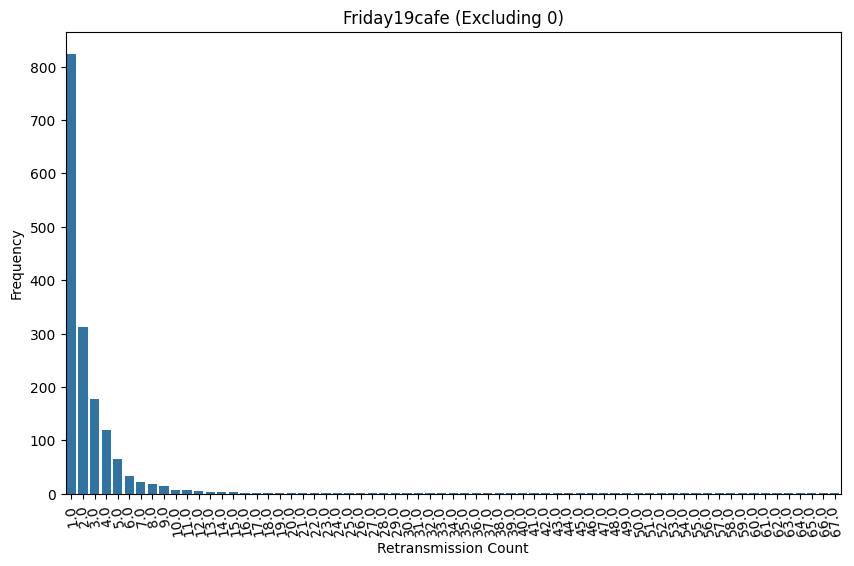

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/FRI19cafe.csv')  

# delete Retransmission Count 为 0 的行
filtered_data = data[data['Retransmission Count'] != 0]  

plt.figure(figsize=(10, 6))
sns.countplot(x='Retransmission Count', data=filtered_data, dodge=False)  

plt.xlabel('Retransmission Count')
plt.ylabel('Frequency')
plt.title('Friday19cafe (Excluding 0)')
plt.xticks(rotation=100)
plt.show()


Draw line charts of retransmissions at three locations

/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/2724545103.py:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')


the number of location：
Loation
Cafe            275668
CSE_Building    270397
Library         214721
Name: count, dtype: int64


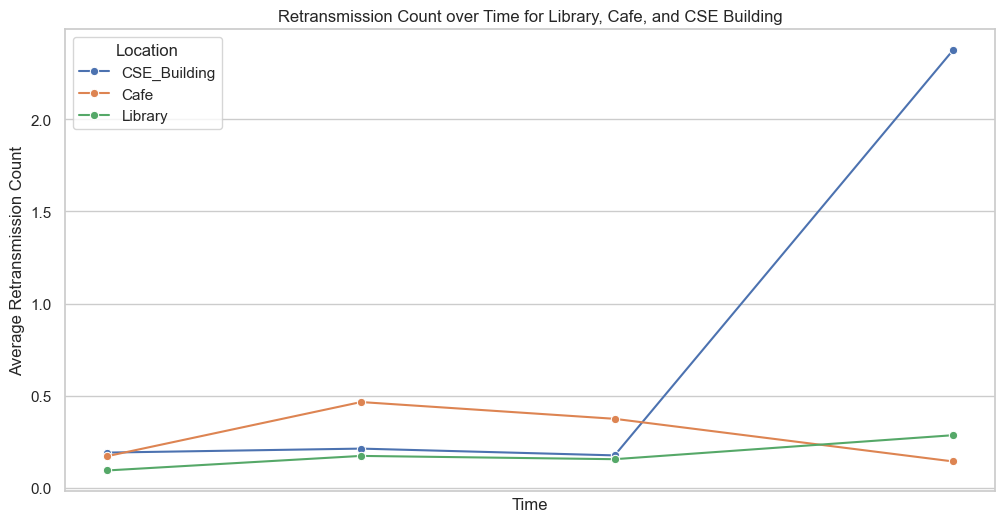

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')  


data['Time_of_day'] = pd.to_datetime(data['Time_of_day'])  


locations = ['Library', 'Cafe', 'CSE_Building']
filtered_data = data[data['Loation'].isin(locations)]

print("the number of location：")
print(filtered_data['Loation'].value_counts())


time_series_data = filtered_data.groupby(['Time_of_day', 'Loation'])['Retry Count'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x='Time_of_day', y='Retry Count', hue='Loation', data=time_series_data, marker='o')

plt.title('Retransmission Count over Time for Library, Cafe, and CSE Building')
plt.xlabel('Time')
plt.ylabel('Average Retransmission Count')
plt.xticks(rotation=45)
plt.legend(title='Location')
plt.grid(True)
plt.show()


Plot retransmission bar graphs at three locations

/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/2451349102.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')


Retry Flag : [0 1]


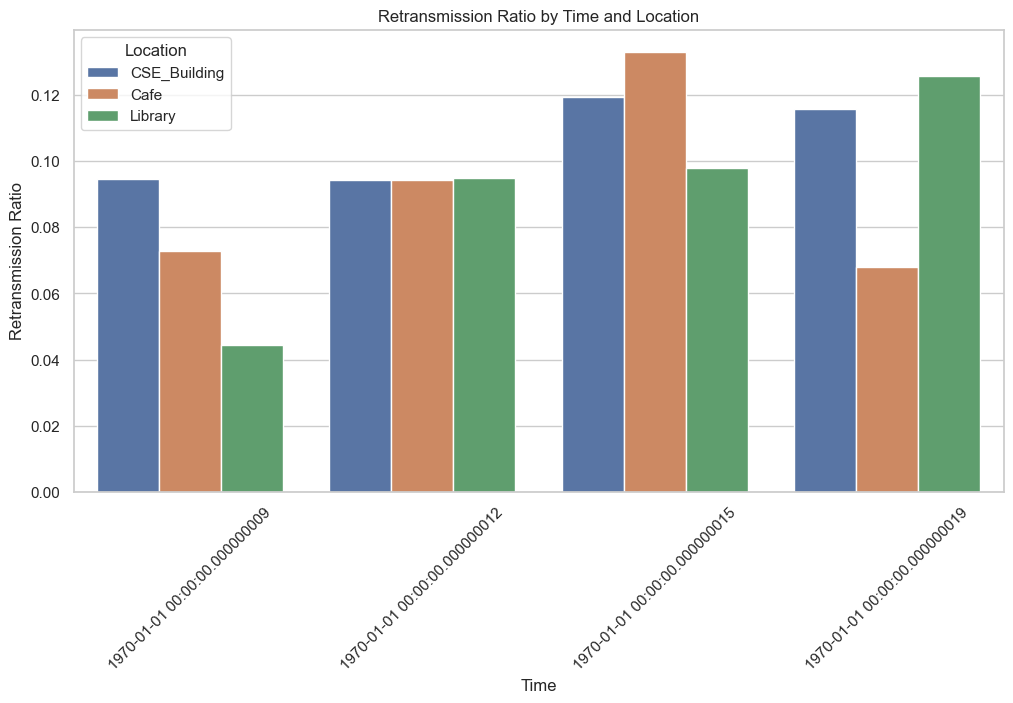

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')  

data['Time_of_day'] = pd.to_datetime(data['Time_of_day'])

print("Retry Flag :", filtered_data['Retry Flag'].unique())

retransmission_stats = (
    filtered_data.groupby(['Time_of_day', 'Loation'])
    .agg(Total_Packets=('Retry Flag', 'count'),  
         Retransmitted_Packets=('Retry Flag', 'sum')) 
    .reset_index()
)


retransmission_stats['Retransmission Ratio'] = retransmission_stats['Retransmitted_Packets'] / retransmission_stats['Total_Packets']

plt.figure(figsize=(12, 6))
sns.barplot(x='Time_of_day', y='Retransmission Ratio', hue='Loation', data=retransmission_stats)

plt.title('Retransmission Ratio by Time and Location')
plt.xlabel('Time')
plt.ylabel('Retransmission Ratio')
plt.xticks(rotation=45)
plt.legend(title='Location')
plt.grid(True, axis='y')

plt.show()


Line plot of latency and throughput

/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/1081269203.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')


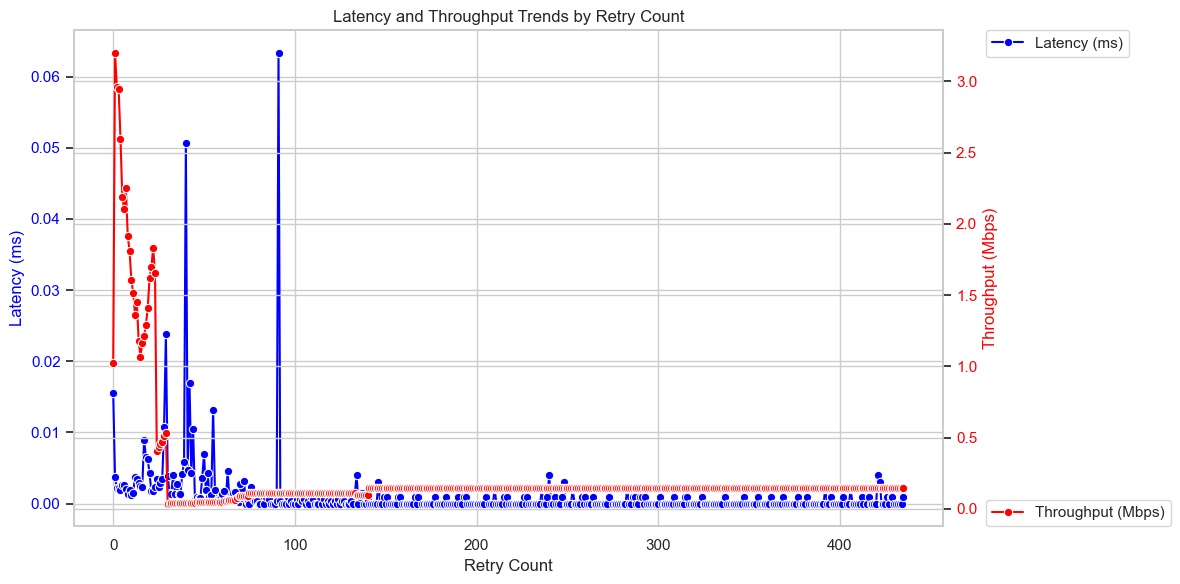

In [77]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')  

# Retry Count、Latency Throughput 
data['Retry Count'] = pd.to_numeric(data['Retry Count'], errors='coerce')
data['Latency'] = pd.to_numeric(data['Latency'], errors='coerce')
data['Throughput'] = pd.to_numeric(data['Throughput'], errors='coerce')


data = data.dropna(subset=['Retry Count', 'Latency', 'Throughput'])

trend_data = data.groupby('Retry Count').agg({'Latency': 'mean', 'Throughput': 'mean'}).reset_index()

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(x='Retry Count', y='Latency', data=trend_data, ax=ax1, color='blue', marker='o', label='Latency (ms)')
ax1.set_xlabel('Retry Count')
ax1.set_ylabel('Latency (ms)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(x='Retry Count', y='Throughput', data=trend_data, ax=ax2, color='red', marker='o', label='Throughput (Mbps)')
ax2.set_ylabel('Throughput (Mbps)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0)

plt.title('Latency and Throughput Trends by Retry Count')
plt.tight_layout() 
plt.show()


Histogram of the number of retransmissions

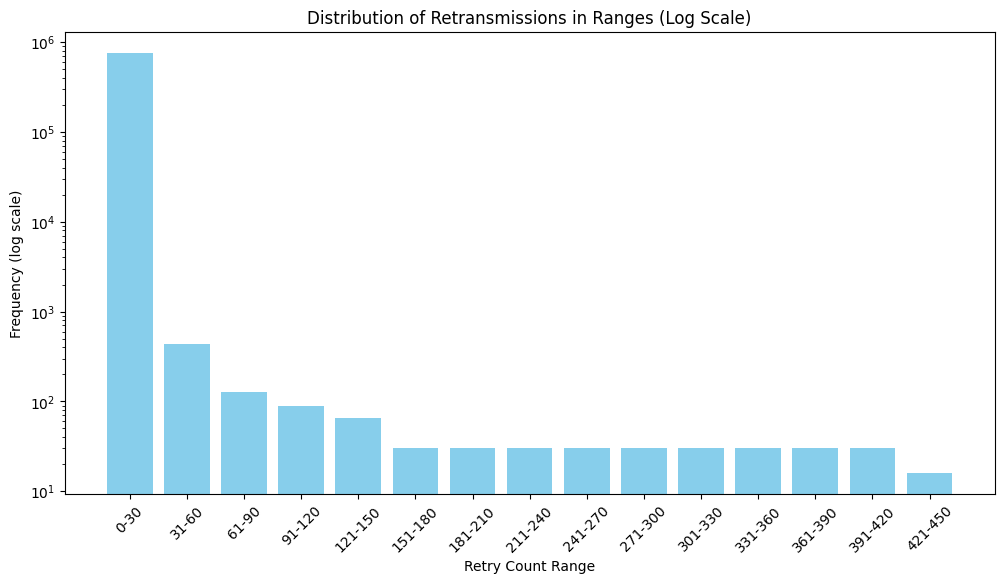

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', encoding='utf_8')  

bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240',
          '241-270', '271-300', '301-330', '331-360', '361-390', '391-420', '421-450']
data['Retry Range'] = pd.cut(data['Retry Count'], bins=bins, labels=labels, right=False)

frequency_data = data['Retry Range'].value_counts().reindex(labels).fillna(0)

plt.figure(figsize=(12, 6))
plt.bar(frequency_data.index, frequency_data.values, color='skyblue')
plt.xlabel('Retry Count Range')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Retransmissions in Ranges (Log Scale)')
plt.yscale('log') 
plt.xticks(rotation=45)
plt.show()

Histogram of latency versus number of retransmissions

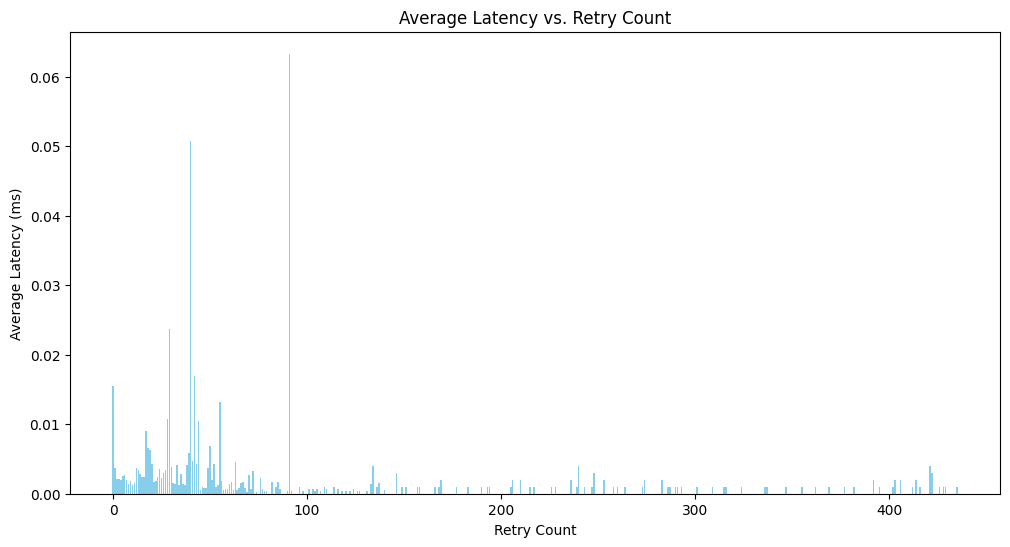

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', encoding='utf_8')  


# average latency
average_latency = data.groupby('Retry Count')['Latency'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(average_latency['Retry Count'], average_latency['Latency'], color='skyblue')
plt.xlabel('Retry Count')
plt.ylabel('Average Latency (ms)')
plt.title('Average Latency vs. Retry Count')
plt.show()



Plot the throughput versus retransmission frequency

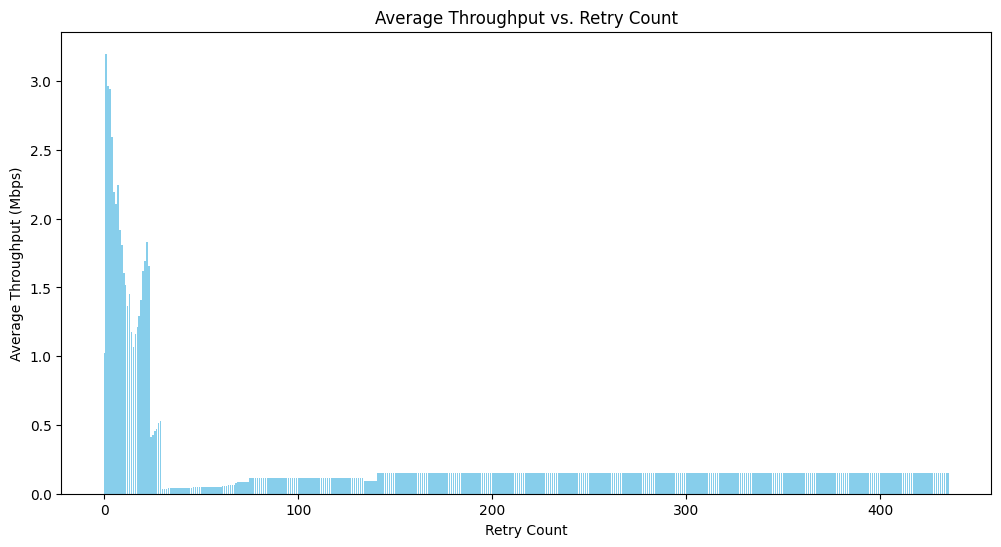

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', encoding='utf_8')  

# throughput
average_throughput = data.groupby('Retry Count')['Throughput'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(average_throughput['Retry Count'], average_throughput['Throughput'], color='skyblue')
plt.xlabel('Retry Count')
plt.ylabel('Average Throughput (Mbps)')
plt.title('Average Throughput vs. Retry Count')
plt.show()


Scatter plot of Channel Utilization versus retransmission frequency

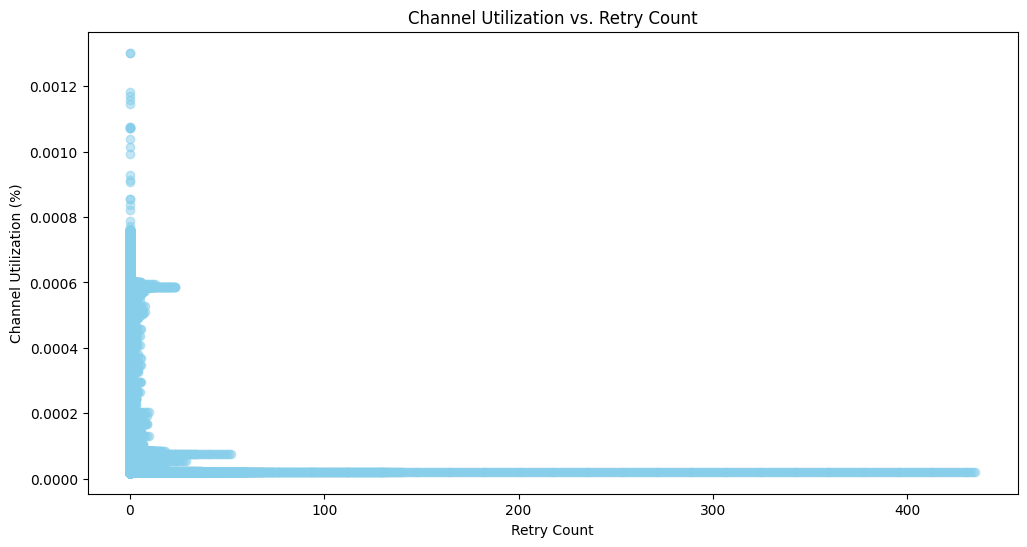

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv', encoding='utf_8')  # 替换为你的文件路径

# Channel Utilization
plt.figure(figsize=(12, 6))
plt.scatter(data['Retry Count'], data['Channel Utilization'], alpha=0.5, color='skyblue')
plt.xlabel('Retry Count')
plt.ylabel('Channel Utilization (%)')
plt.title('Channel Utilization vs. Retry Count')
plt.show()


Data preprocessing

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

data = pd.read_csv('/Users/macbook/Desktop/9336/dataset/new_all.csv')

data.drop(columns=['Time', 'absolute time','Frequency','Info'], inplace=True, errors='ignore')

# OneHot- location and frame type
location_encoded = pd.get_dummies(data['Loation'], prefix='Loation')
frame_type_encoded = pd.get_dummies(data['Frame Type'], prefix='Frame_Type')

# Onehot-encoded columns are added to the dataset and the original columns are removed
data = pd.concat([data, location_encoded, frame_type_encoded], axis=1)
data.drop(['Loation', 'Frame Type'], axis=1, inplace=True)

# label Time_of_day, Day, Source, Destination
label_encoders = {}
for col in ['Time_of_day', 'Day', 'Source', 'Destination']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  


# Check and fill in missing values
imputer = SimpleImputer(strategy="median")
data.iloc[:, :] = imputer.fit_transform(data)

# The numerical features are normalized using StandardScaler
scaler = StandardScaler()
num_features = ['Sequence Number', 'Retry Count', 'Latency', 
                'Signal Strength', 'Packet Size', 'Throughput', 'Channel Utilization']

data[num_features] = scaler.fit_transform(data[num_features])

# Retransmission Flag
X = data.drop(['Retry Flag'], axis=1)
y = data['Retry Flag']

# Train&Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Done!")
data.head()


/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/1570358483.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Latency'].fillna(data['Latency'].median(), inplace=True)
/var/folders/hb/tg5fw4t50qg9g10swwkz64dr0000gn/T/ipykernel_23662/1570358483.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.iloc[:, :] = imputer.

Done!


,No.,Source,Destination,Protocol,Packet Size,Signal Strength,Noise level,Signal/noise ratio,Channel,Time_of_day,...,Sequence Number,Retry Flag,Retry Count,Latency,Channel Utilization,Throughput,Loation_CSE_Building,Loation_Cafe,Loation_Library,Frame_Type_Data
0,1,50198,42050,802.11,-0.013607,-0.329960,-92.0,14.0,165,2,...,0.774812,0,-0.054914,-0.008836,-0.013575,-0.339087,0.0,1.0,0.0,1.0
1,2,77569,42533,802.11,-1.126958,-0.846330,-92.0,14.0,165,2,...,-0.917982,1,-0.054914,-0.009479,-1.126942,-0.334324,0.0,1.0,0.0,1.0
2,3,77569,42533,802.11,-1.126958,-0.846330,-92.0,14.0,165,2,...,-0.917982,1,0.102259,-0.009479,-1.126942,-0.334324,0.0,1.0,0.0,1.0
3,4,77569,42533,802.11,-1.126958,-0.949603,-92.0,14.0,165,2,...,-0.917982,1,0.259433,-0.008193,-1.126942,-0.334324,0.0,1.0,0.0,1.0
4,8,77569,42533,802.11,-1.126958,-1.052877,-92.0,14.0,165,2,...,-0.917149,1,-0.054914,-0.008193,-1.126942,-0.334324,0.0,1.0,0.0,1.0


KNN

In [34]:
#knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# knn model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print("KNN Model Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))



KNN Model Accuracy: 0.9505643281515624
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97    206337
           1       0.73      0.77      0.75     21899

    accuracy                           0.95    228236
   macro avg       0.85      0.87      0.86    228236
weighted avg       0.95      0.95      0.95    228236

Confusion Matrix:
 [[200176   6161]
 [  5122  16777]]


Random forest

In [35]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Model Accuracy: 0.9753106433691442
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    206337
           1       0.92      0.81      0.86     21899

    accuracy                           0.98    228236
   macro avg       0.95      0.90      0.92    228236
weighted avg       0.97      0.98      0.97    228236



Feature extraction

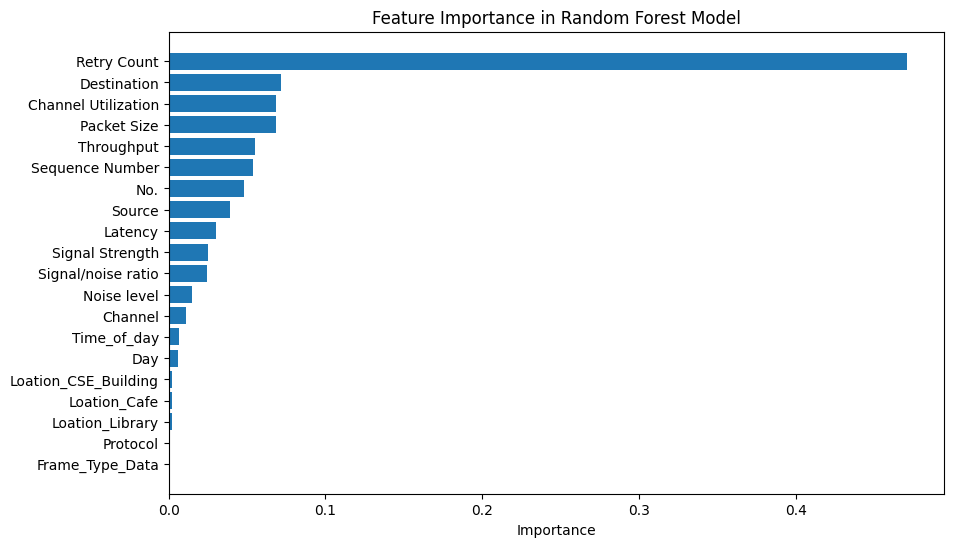

In [36]:

import pandas as pd
import matplotlib.pyplot as plt


feature_importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

                 